##Requirements

**ATENÇÃO**: A sessão será reiniciada para permitir que as dependências sejam devidamente carregadas. Após isso, execute as celúlas abaixo dessa normalmenlte.

In [3]:
!pip install gdown
!pip install networkx matplotlib
!pip install -U spacy
!python -m spacy download pt_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 3.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import pandas as pd
import spacy
import re
import nltk
from nltk.corpus import stopwords
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns

nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

nlp = spacy.load('pt_core_news_lg')


# Substitua os links do Google Drive pelas URLs "raw" do GitHub
url_raw_lexicon = 'https://raw.githubusercontent.com/LorenaSouzaMoreiraa/RedesComplexas-TpIntermediario/refs/heads/main/dados/mol.csv'
url_raw_messages = 'https://raw.githubusercontent.com/LorenaSouzaMoreiraa/RedesComplexas-TpIntermediario/refs/heads/main/dados/2019-05-28_portuguese_hate_speech_binary_classification.csv'

# Carrega os dados diretamente da URL para os DataFrames
print("Carregando dados diretamente do GitHub...")
dflexicon = pd.read_csv(url_raw_lexicon)
dfmessages = pd.read_csv(url_raw_messages)
print("DataFrames carregados com sucesso.")

# Exibe as primeiras linhas para confirmar
print("\nLexicon:")
print(dflexicon.head())
print("\nMessages:")
print(dfmessages.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Carregando dados diretamente do GitHub...
DataFrames carregados com sucesso.

Lexicon:
  term-or-expression explicit-or-implicit pt-brazilian-portuguese  \
0               term             explicit                 chorume   
1               term             explicit                baixaria   
2               term             explicit                      cu   
3         expression             explicit            cu pra tomar   
4               term             explicit               vagabundo   

   pt-contextual-label pt-hate-label  pt-deeply-culture-rooted  \
0                  1.0             0                       0.0   
1                  1.0             0                       0.0   
2                  0.0             0                       0.0   
3                  1.0             0                       0.0   
4                  1.0             0                       0.0   

  en-american-english  en-contextual-label en-hate-label es-latin-spanish  \
0              rotten   

##Pré-processamento

In [5]:
# 1. Criar um DataFrame contendo apenas a coluna 'pt-brazilian-portuguese'
df_hate_words = dflexicon[['pt-brazilian-portuguese']].rename(columns={'pt-brazilian-portuguese': 'exp'})
print("DataFrame com os termos em português:")
print(df_hate_words.head())

print("\n" + "="*50 + "\n") # Adiciona um separador para clareza

# 2. Filtrar mensagens onde a soma dos votos de 'hatespeech' é 2 ou mais
# Isso seleciona as linhas onde pelo menos dois dos três anotadores marcaram como discurso de ódio (1).
df_hate_messages =  dfmessages.loc[
    (dfmessages['hatespeech_G1'] + dfmessages['hatespeech_G2'] + dfmessages['hatespeech_G3']) >= 2,
    ['text']
]
print("DataFrame com mensagens de discurso de ódio (2 ou mais votos):")
print(df_hate_messages.head())

DataFrame com os termos em português:
            exp
0       chorume
1      baixaria
2            cu
3  cu pra tomar
4     vagabundo


DataFrame com mensagens de discurso de ódio (2 ou mais votos):
                                                 text
0   @__andrea__b \nO cara vive em outro mundo\nNão...
4                 @_iglira bom dia macaco branco haha
17  @_latinlover_ Perfume pra mão jovem amante.......
18  @_Nabarra 'Estimo que se foda' será mais profi...
19        @_NandaSilva_ bom dia sapatao da minha vida


Retirar menções, hashtags, '\n' e outros

In [6]:
# 1. Definir a função de limpeza
def limpar_texto(texto):
    if not isinstance(texto, str):
        return ""
    # Remove URLs
    texto = re.sub(r'http\S+|www\S+', '', texto)
    # Remove menções (@usuario)
    texto = re.sub(r'@\w+', '', texto)
    # Remove hashtags (#assunto)
    texto = re.sub(r'#\w+', '', texto)
    # Remove a marcação de "RT" (Retweet)
    texto = re.sub(r'RT', '', texto)
    # Remove caracteres de nova linha (\n) e os substitui por espaço
    texto = re.sub(r'\n', ' ', texto)
    # Remove caracteres especiais, pontuações e números, deixando apenas letras e espaços
    texto = re.sub(r'[^\w\s]', '', texto)
    # Remove espaços em branco extras (deixa apenas um espaço entre as palavras)
    texto = re.sub(r'\s+', ' ', texto).strip()

    # --- Remoção de Stop Words ---
    # 1. Converte o texto para minúsculas e divide em palavras (tokens)
    palavras = texto.lower().split()

    # Processa o texto com o modelo spaCy
    doc = nlp(texto)

    # 2. Remove as stop words e lematização
    lemas = [token.lemma_.lower() for token in doc if not token.is_stop and token.text.strip()]

    # 3. Junta as palavras novamente em uma única string
    texto_final = ' '.join(lemas)

    return texto_final

# 2. Aplicar a função na coluna 'text' e criar uma nova coluna 'texto_limpo'
df_hate_messages['pro-text'] = df_hate_messages['text'].apply(limpar_texto)

# 3. Exibir o resultado
print("Textos Originais vs. Textos Limpos:")
print(df_hate_messages[['text', 'pro-text']])

Textos Originais vs. Textos Limpos:
                                                   text  \
0     @__andrea__b \nO cara vive em outro mundo\nNão...   
4                   @_iglira bom dia macaco branco haha   
17    @_latinlover_ Perfume pra mão jovem amante.......   
18    @_Nabarra 'Estimo que se foda' será mais profi...   
19          @_NandaSilva_ bom dia sapatao da minha vida   
...                                                 ...   
5655  @xicoxivucu O Islão não é uma religião como as...   
5661      @Yasmim_Ramaldes Tô esperando a sapatão fazer   
5666  @zqkitowz sei das cotas, mas não sabia disso, ...   
5668  @zurcju seguir no tt é facíl, apresentar as am...   
5669  na vdd a culpa é do menino de 11 anos otário q...   

                                               pro-text  
0     cara viver outro mundo mundo real refugiados v...  
4                                dia macaco branco haha  
17          perfume pra mão jovem amantepra mão cappice  
18                     

In [7]:
# 1. Encontra o índice da linha que contém a string mais longa
idx_maior_expressao = df_hate_words['exp'].str.len().idxmax()

# 2. Usa o índice para buscar a expressão no DataFrame original
maior_expressao = df_hate_words.loc[idx_maior_expressao, 'exp']

print(f"A maior expressão encontrada é: '{maior_expressao}'")

df_hate_words['pro-exp'] = df_hate_words['exp'].apply(limpar_texto)

# Compara a coluna original 'exp' com a nova coluna processada 'pro-exp'
print("\nHateword Originais vs. Hateword Processado:")
print(df_hate_words[['exp', 'pro-exp']].head())

# 1. Encontra o índice da linha que contém a string mais longa
idx_maior_expressao = df_hate_words['pro-exp'].str.len().idxmax()

# 2. Usa o índice para buscar a expressão no DataFrame original
maior_expressao = df_hate_words.loc[idx_maior_expressao, 'pro-exp']

print(f"\nA maior expressão encontrada lematizada é: '{maior_expressao}'")

A maior expressão encontrada é: 'joga uma carteira de trabalho que correm todos'

Hateword Originais vs. Hateword Processado:
            exp       pro-exp
0       chorume       chorume
1      baixaria        baixar
2            cu            cu
3  cu pra tomar  cu pra tomar
4     vagabundo    vagabundar

A maior expressão encontrada lematizada é: 'conseguir formular frase inteiro'


## Rede Complexa

In [8]:
# 1. Inicializar um grafo não direcionado
G = nx.Graph()

# 2. Iterar sobre cada texto processado para construir o grafo
for texto in df_hate_messages['pro-text']:
    palavras = texto.split()

    # Adicionar nós e contar frequência
    for palavra in palavras:
        if G.has_node(palavra):
            G.nodes[palavra]['count'] += 1
        else:
            # Adiciona o nó com um atributo 'count'
            G.add_node(palavra, count=1)

    # Adicionar arestas e pesos
    for i in range(len(palavras) - 1):
        palavra1 = palavras[i]
        palavra2 = palavras[i+1]

        if G.has_edge(palavra1, palavra2):
            G.edges[palavra1, palavra2]['weight'] += 1
        else:
            # Adiciona a aresta com um atributo 'weight'
            G.add_edge(palavra1, palavra2, weight=1)

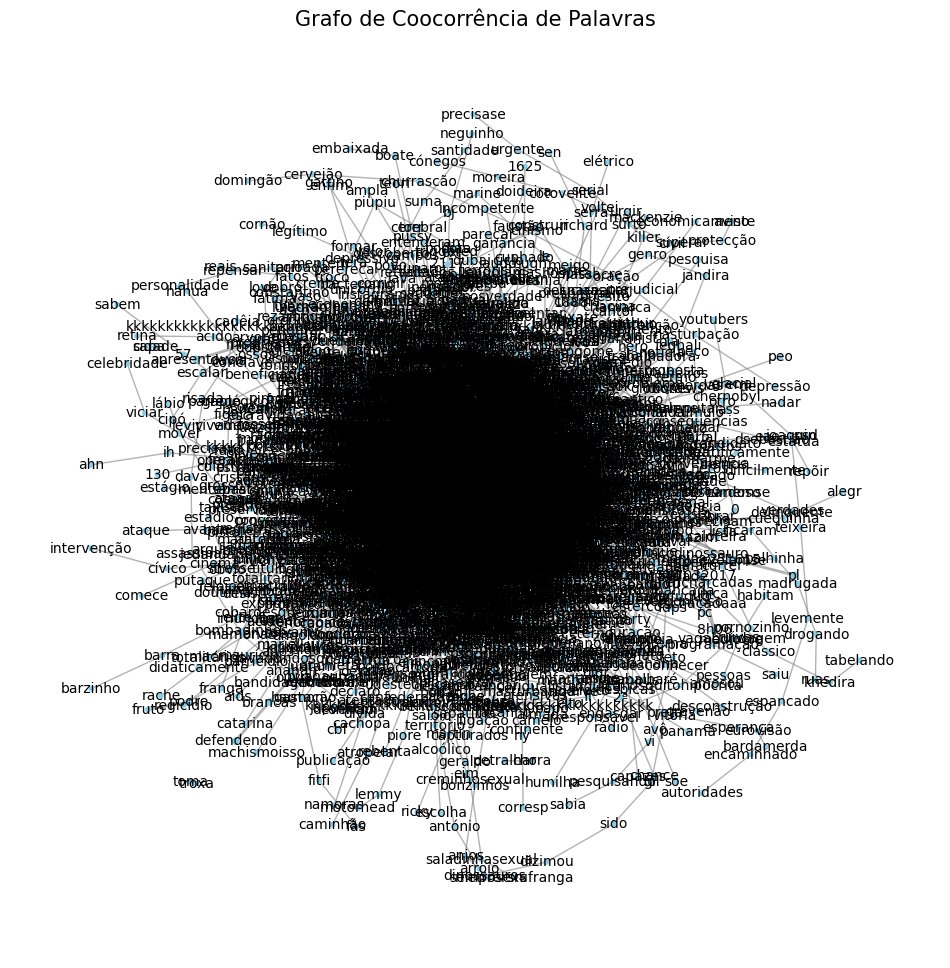

Número de nós (palavras únicas): 4909
Número de arestas (conexões únicas): 11083


In [9]:
# Tamanho dos nós proporcional à frequência da palavra (count)
node_sizes = [G.nodes[n]['count'] * 10 for n in G.nodes()]

# Largura das arestas proporcional ao peso (weight)
edge_widths = [G.edges[e]['weight'] for e in G.edges()]

# Definir o layout do grafo
pos = nx.spring_layout(G, k=0.35, iterations=50)

# 4. Desenhar o grafo
plt.figure(figsize=(12, 12))

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title("Grafo de Coocorrência de Palavras", size=15)
plt.axis('off') # Remove os eixos x e y
plt.show()

# Opcional: Imprimir informações sobre o grafo criado
print(f"Número de nós (palavras únicas): {G.number_of_nodes()}")
print(f"Número de arestas (conexões únicas): {G.number_of_edges()}")

### (b) Grau dos Nós

O grau médio do grafo é: 4.52
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 41, 42, 45, 46, 47, 48, 52, 53, 54, 56, 57, 65, 69, 70, 71, 74, 78, 80, 81, 83, 84, 85, 91, 93, 97, 102, 104, 105, 107, 111, 116, 117, 123, 198, 264, 287, 302) (764, 2541, 285, 446, 119, 154, 65, 71, 46, 55, 43, 37, 27, 17, 23, 22, 19, 19, 8, 9, 8, 10, 5, 11, 7, 2, 7, 2, 3, 6, 2, 3, 4, 4, 2, 1, 2, 2, 3, 3, 4, 1, 2, 1, 3, 2, 4, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)


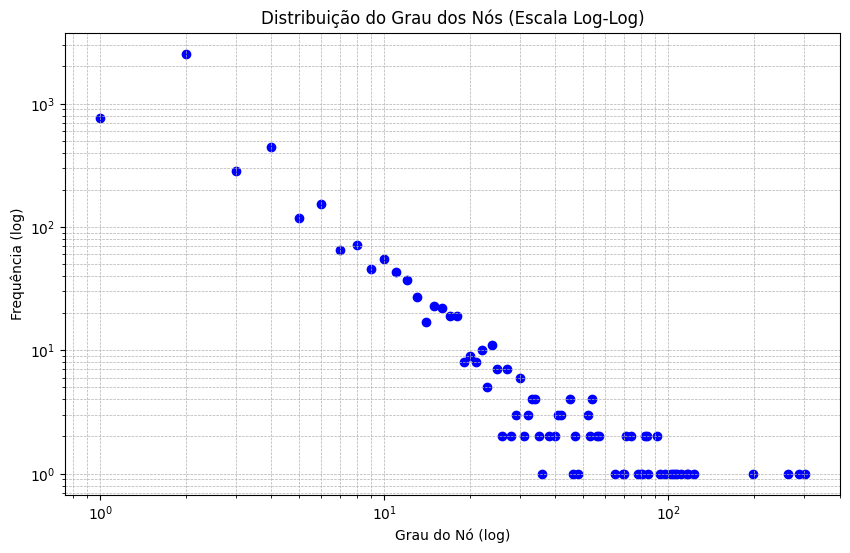

In [10]:
# Cálculo do grau médio
grau_total = sum(d for n, d in G.degree())
grau_medio = grau_total / G.number_of_nodes()
print(f"O grau médio do grafo é: {grau_medio:.2f}")

# Preparação dos dados
graus = [d for n, d in G.degree()]
contagem_de_graus = Counter(graus)
grau, contagem = zip(*sorted(contagem_de_graus.items()))

print(grau, contagem)

# Plot (Modificado para scatter plot com escala log-log)
plt.figure(figsize=(10, 6))
plt.scatter(grau, contagem, color='blue', marker='o') # Scatter plot
plt.xscale('log') # Eixo X em escala logarítmica
plt.yscale('log') # Eixo Y em escala logarítmica
plt.title("Distribuição do Grau dos Nós (Escala Log-Log)")
plt.ylabel("Frequência (log)")
plt.xlabel("Grau do Nó (log)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

### (c) Número de Componentes


In [11]:
# 1. Encontra os componentes conectados e os ordena por tamanho (do maior para o menor)
componentes_conectados = sorted(nx.connected_components(G), key=len, reverse=True)
num_componentes = len(componentes_conectados)
print(f"O número de componentes conectados no grafo é: {len(componentes_conectados)}")

# 2. Prepara uma lista para armazenar os dados de cada componente
dados_dos_componentes = []

# 3. Itera sobre cada componente para extrair suas informações
for i, componente_nodes in enumerate(componentes_conectados):
    # Cria um subgrafo contendo apenas os nós e arestas do componente atual
    subgrafo = G.subgraph(componente_nodes)

    # Calcula o número de nós e arestas do subgrafo
    num_nos = subgrafo.number_of_nodes()
    num_arestas = subgrafo.number_of_edges()

    # Adiciona os dados à lista
    dados_dos_componentes.append({
        'Componente ID': i + 1,
        'Nº de Nós': num_nos,
        'Nº de Arestas': num_arestas
    })

# 4. Cria um DataFrame do Pandas com os dados e o exibe
df_componentes = pd.DataFrame(dados_dos_componentes)

print("\nAnálise dos Componentes Conectados:")
print(df_componentes)

O número de componentes conectados no grafo é: 10

Análise dos Componentes Conectados:
   Componente ID  Nº de Nós  Nº de Arestas
0              1       4873          11056
1              2          7              6
2              3          7              6
3              4          7              6
4              5          4              3
5              6          3              2
6              7          2              1
7              8          2              1
8              9          2              1
9             10          2              1


### (d) Coeficiente de Clusterização


O coeficiente de clusterização global do grafo é: 0.0512
Coeficientes locais: [0.045348293595137916, 0.04411764705882353, 0.022222222222222223, 0.03367003367003367, 0.007352941176470588, 0.06666666666666667, 0, 0, 0, 0.029975429975429974, 0.2, 0.04338487972508591, 0, 0, 0.01541882876204596, 0.11428571428571428, 0.027777777777777776, 1.0, 0, 0, 0.029411764705882353, 0.024790083966413436, 0, 0.02922077922077922, 0.022067363530778164, 0.09038461538461538, 0.03221029248426509, 0, 0, 0.040123456790123455, 0.05924978687127025, 0.01714604236343367, 0.06521739130434782, 0.035164835164835165, 0, 0, 0, 0.05454545454545454, 0.07608695652173914, 0, 0, 0.027790715727371525, 0, 0, 0.16666666666666666, 0.05365853658536585, 0.018292682926829267, 0.022222222222222223, 0.026559356136820925, 0.03636363636363636, 0.3333333333333333, 0, 0.0196078431372549, 0.0453781512605042, 0.033197437390797904, 0.0380952380952381, 0.05714285714285714, 0, 0, 0, 0, 0, 0.017421602787456445, 0.07509881422924901, 0.083333333

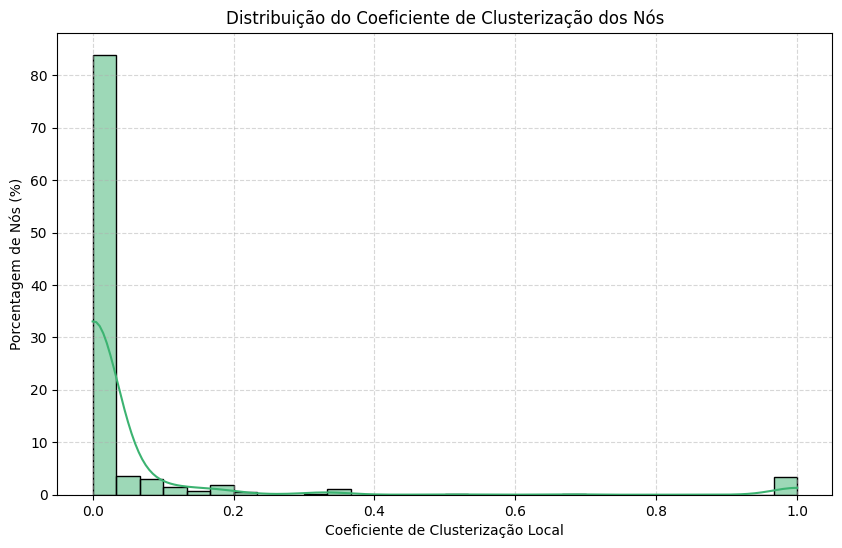

In [12]:
coef_cluster_medio = nx.average_clustering(G)
print(f"O coeficiente de clusterização global do grafo é: {coef_cluster_medio:.4f}")

# Coeficientes locais
coeficientes_locais = list(nx.clustering(G).values())

print(f"Coeficientes locais: {coeficientes_locais}")

# Plot com Seaborn (modificado para porcentagem)
plt.figure(figsize=(10, 6))
sns.histplot(
    coeficientes_locais,
    bins=30,
    kde=True,
    color='mediumseagreen',
    stat='percent'  # <-- MUDANÇA PRINCIPAL AQUI
)
plt.title("Distribuição do Coeficiente de Clusterização dos Nós")
plt.xlabel("Coeficiente de Clusterização Local")
plt.ylabel("Porcentagem de Nós (%)")  # <-- RÓTULO DO EIXO Y ATUALIZADO
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### (e) Tamanho dos Componentes

Tamanhos dos componentes: [4873, 7, 7, 7, 4, 3, 2, 2, 2, 2]


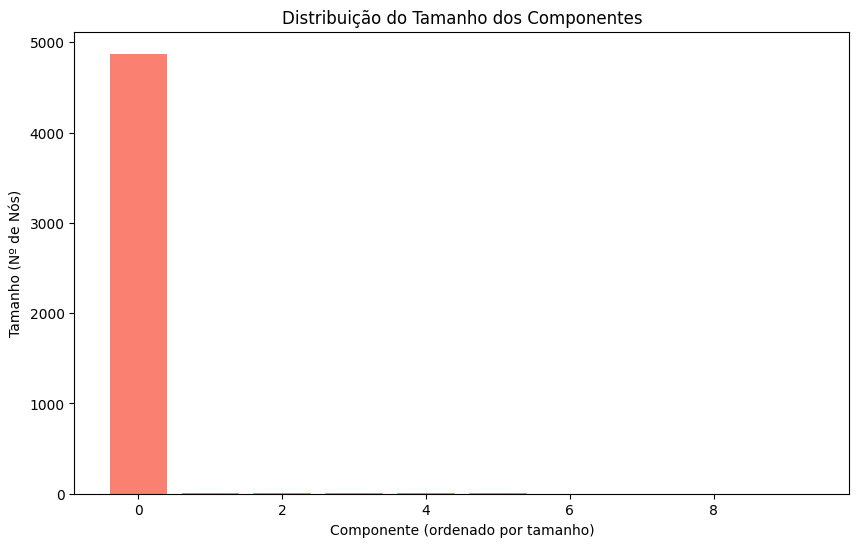

In [13]:
if num_componentes > 1:
    componentes = sorted(nx.connected_components(G), key=len, reverse=True)
    tamanho_componentes = [len(c) for c in componentes]

    print(f"Tamanhos dos componentes: {tamanho_componentes}")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(tamanho_componentes)), tamanho_componentes, color='salmon')
    plt.title("Distribuição do Tamanho dos Componentes")
    plt.xlabel("Componente (ordenado por tamanho)")
    plt.ylabel("Tamanho (Nº de Nós)")
    plt.show()
else:
    print("O grafo possui apenas um componente, não é necessário plotar a distribuição.")

### (f) Overlap da Vizinhança

[0. 0. 0. ... 0. 0. 0.]


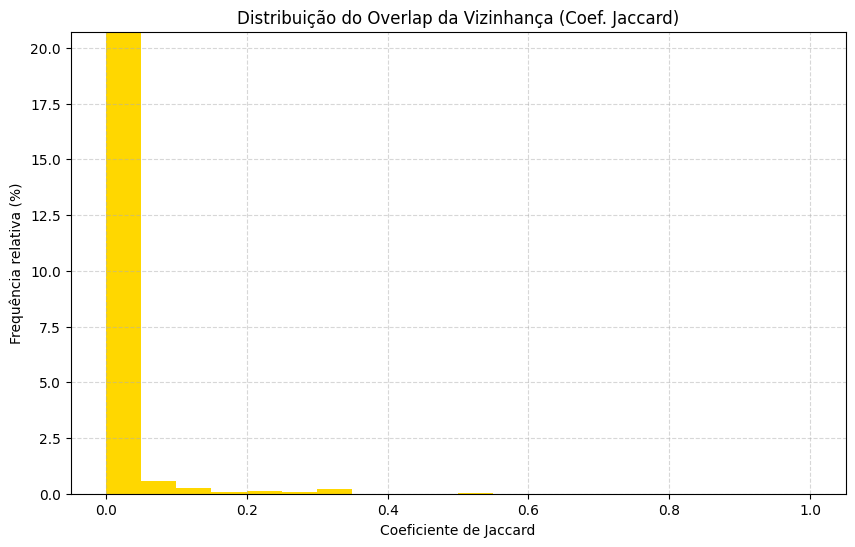

In [14]:
# Calcular os coeficientes de Jaccard apenas para pares não conectados
overlaps = [p for u, v, p in nx.jaccard_coefficient(G)]

# Conversão para array NumPy
overlaps_array = np.array(overlaps)

print(overlaps_array)

# Plot com porcentagem
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(overlaps_array, bins=20, color='gold', density=True)

# Converter para porcentagem
for i in range(len(patches)):
    height = counts[i] * (bins[i+1] - bins[i]) * 100
    patches[i].set_height(height)

plt.ylabel("Frequência relativa (%)")
plt.xlabel("Coeficiente de Jaccard")
plt.title("Distribuição do Overlap da Vizinhança (Coef. Jaccard)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### (g) Distâncias na Rede

In [ ]:
if num_componentes > 0:
    # Pega o maior componente conectado
    maior_componente_nodes = max(nx.connected_components(G), key=len)
    S = G.subgraph(maior_componente_nodes)

    # Distância média (requer que o grafo seja conectado)
    distancia_media = nx.average_shortest_path_length(S)
    print(f"A distância média no maior componente conectado é: {distancia_media:.2f}")

    # Distribuição de todas as distâncias
    comprimentos = []
    for source, paths in nx.all_pairs_shortest_path_length(S):
        comprimentos.extend(paths.values())

    contagem_de_comprimentos = Counter(c for c in comprimentos if c > 0)
    dist, cont = zip(*sorted(contagem_de_comprimentos.items()))

    print(dist, cont)
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(dist, cont, color='mediumpurple')
    plt.title("Distribuição das Distâncias na Rede")
    plt.xlabel("Distância (Caminho Mínimo)")
    plt.ylabel("Frequência")
    plt.show()
else:
    print("Grafo não possui nós, não é possível calcular distâncias.")

### (h) Visualização do Grafo

In [ ]:
print("Plotando uma visualização do maior componente conectado...")

# Usaremos o subgrafo 'S' do maior componente, calculado no passo anterior
if 'S' in locals() and S.number_of_nodes() > 0:
    pos = nx.spring_layout(S, seed=42)
    node_sizes = [d['count'] * 100 for n, d in S.nodes(data=True)]
    edge_widths = [d['weight'] for u, v, d in S.edges(data=True)]

    plt.figure(figsize=(15, 15))
    nx.draw(S, pos, with_labels=True, node_size=node_sizes, width=edge_widths,
            node_color="skyblue", edge_color="gray", font_size=10)
    plt.title("Visualização do Maior Componente Conectado do Grafo")
    plt.show()
else:
    print("Não foi possível gerar a visualização (grafo ou componente vazio).")